## Imports and settings

In [15]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
from pprint import pprint
import collections

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm as CM
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from tqdm import tqdm

project_root = '..'
sys.path.append(project_root)

from sleeprnn.data.loader import load_dataset, RefactorUnpickler
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import metrics
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.common import constants, pkeys

SEED_LIST = [123, 234, 345, 456]
RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
DPI = 200
CUSTOM_COLOR = {'red': '#c62828', 'grey': '#455a64', 'blue': '#0277bd', 'green': '#43a047', 'dark':'#1b2631'} 

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Scaling

In [32]:
# Model: BSF Mixed
ckpt_folder = os.path.join(
        '20190617_grid_normalization_n2_train_mass_ss',
        'norm_global')
id_try = 0
optimal_thr_list = [0.58, 0.42, 0.4, 0.5]
dataset_name = constants.MASS_SS_NAME
task_mode = constants.N2_RECORD
which_expert = 1
set_name = constants.TRAIN_SUBSET

# ---- Load stuff
scaling_optimal_thr = optimal_thr_list[id_try]
prediction_folder = os.path.join(RESULTS_PATH, 'scaling_results', ckpt_folder, 'seed%d' % id_try)
filenames = os.listdir(prediction_folder)
filenames = [fn for fn in filenames if set_name in fn]
filenames.sort()
scale_list = [float(single_filename[-8:-4]) for single_filename in filenames]
scale_list = np.array(scale_list)
predictions_dict = {}
for scale, file in zip(scale_list, filenames):
    print('Loading scale %1.2f on file %s' % (scale, file))
    with open(os.path.join(prediction_folder, file), 'rb') as handle:
        predictions_dict[scale] = RefactorUnpickler(handle).load()
print('Optimal thr for scaling experiment %1.2f (seed %d)' % (scaling_optimal_thr, id_try))

dataset = load_dataset(dataset_name)
ids_dict = {
    constants.TRAIN_SUBSET: dataset.train_ids,
    constants.TEST_SUBSET: dataset.test_ids
}

data_inference = FeederDataset(
    dataset, ids_dict[set_name], task_mode, which_expert=which_expert)
this_events = data_inference.get_stamps()

# Measure performance
print('Measuring performance', flush=True)
iou_thr = 0.3
scaling_stats = {}
for scale in scale_list:
    prediction_set = predictions_dict[scale]
    prediction_set.set_probability_threshold(scaling_optimal_thr)
    this_detections = prediction_set.get_stamps()
    scaling_stats[scale] = [
        metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
        for (this_y, this_y_pred) in zip(this_events, this_detections)]
print('Done')

Loading scale 0.50 on file prediction_n2_train_s0.50.pkl
Loading scale 0.55 on file prediction_n2_train_s0.55.pkl
Loading scale 0.60 on file prediction_n2_train_s0.60.pkl
Loading scale 0.65 on file prediction_n2_train_s0.65.pkl
Loading scale 0.70 on file prediction_n2_train_s0.70.pkl
Loading scale 0.75 on file prediction_n2_train_s0.75.pkl
Loading scale 0.80 on file prediction_n2_train_s0.80.pkl
Loading scale 0.85 on file prediction_n2_train_s0.85.pkl
Loading scale 0.90 on file prediction_n2_train_s0.90.pkl
Loading scale 0.95 on file prediction_n2_train_s0.95.pkl
Loading scale 1.00 on file prediction_n2_train_s1.00.pkl
Loading scale 1.05 on file prediction_n2_train_s1.05.pkl
Loading scale 1.10 on file prediction_n2_train_s1.10.pkl
Loading scale 1.15 on file prediction_n2_train_s1.15.pkl
Loading scale 1.20 on file prediction_n2_train_s1.20.pkl
Loading scale 1.25 on file prediction_n2_train_s1.25.pkl
Loading scale 1.30 on file prediction_n2_train_s1.30.pkl
Loading scale 1.35 on file pred

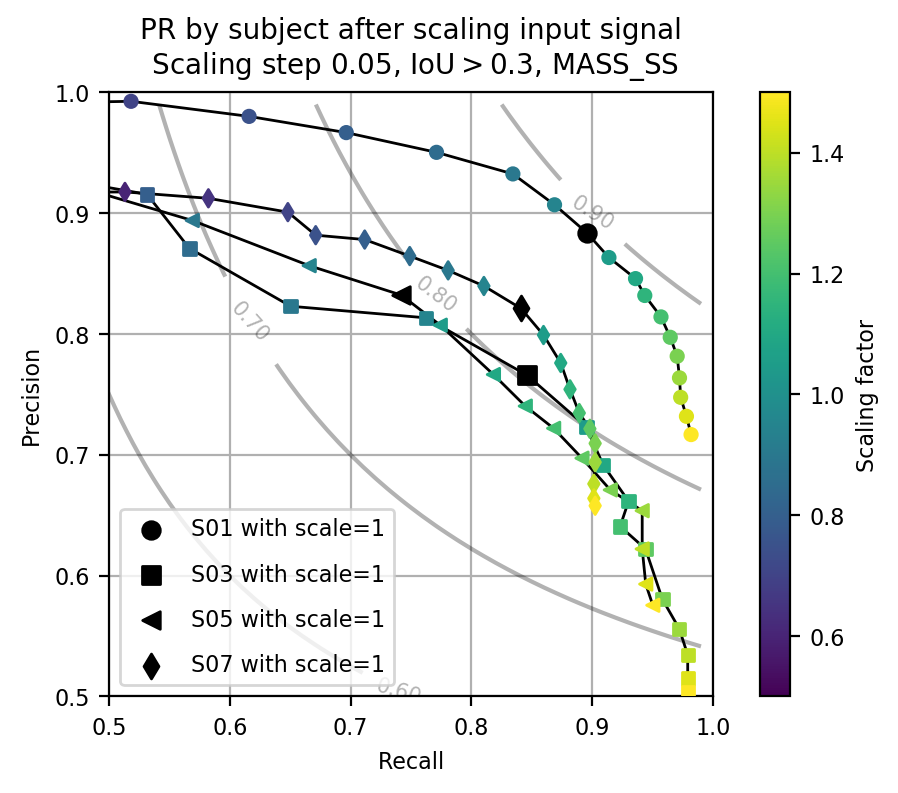

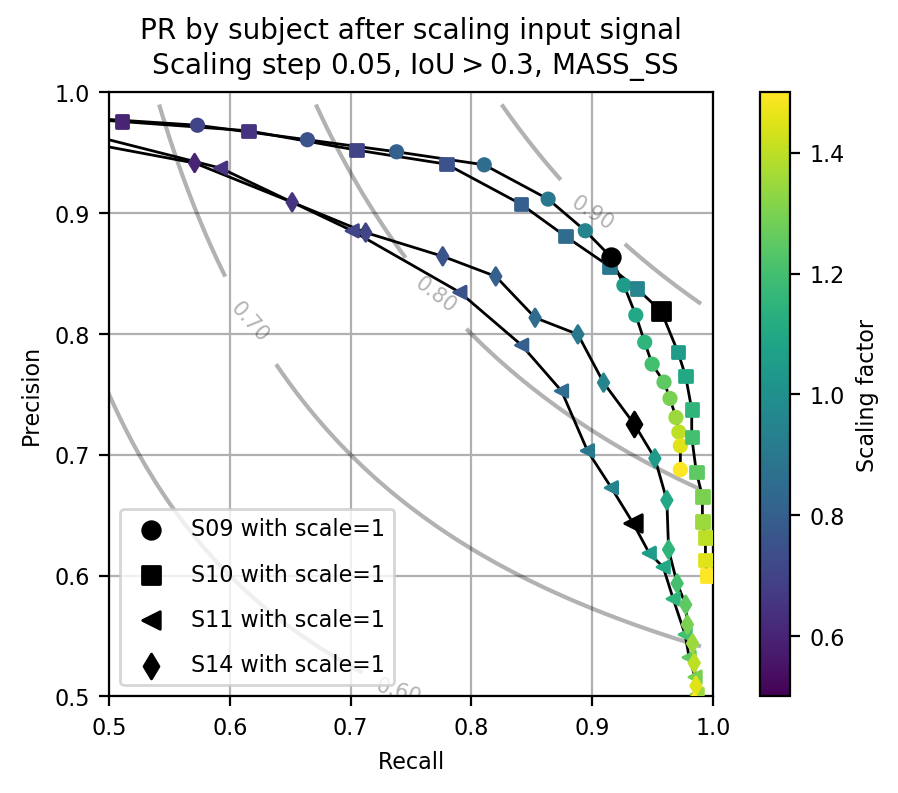

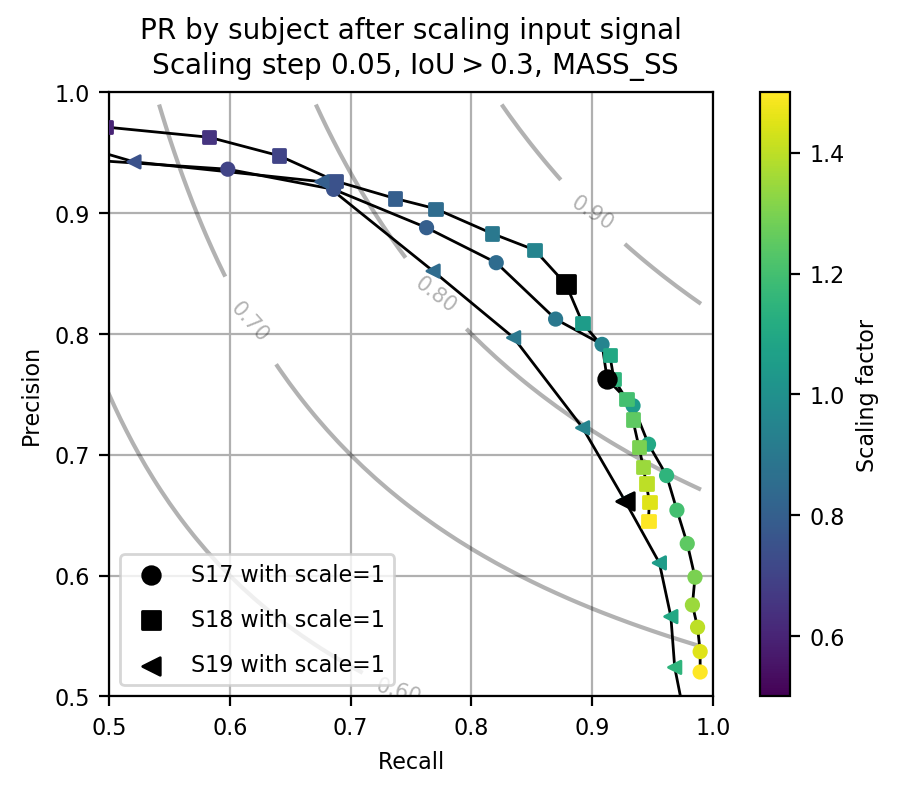

In [33]:
# Plot
if set_name == constants.TEST_SUBSET:
    n_plots = 1
else:
    n_plots = 3

title_fontsize = 10
other_fontsize = 8
markersize = 20
alpha = 0.4
text_space = 0.01
axis_lims = [0.5, 1.0]

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)
levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
levels = [level for level in levels if (level>axis_lims[0] and level<axis_lims[1])]

for id_plot in range(n_plots):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=DPI)
    CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
    ax.clabel(CS, fontsize=7.5, fmt='%1.2f')
    marker_list = ['o', 's', '<', 'd']
    end_range = min(4 * (id_plot+1), len(ids_dict[set_name]))
    for i_inner, i in enumerate(range(id_plot*4, end_range)):
        subject_id = ids_dict[set_name][i]
        this_recall = [scaling_stats[scale][i]['recall'] for scale in scale_list]
        this_precision = [scaling_stats[scale][i]['precision'] for scale in scale_list]
        scat = ax.scatter(this_recall, this_precision, c=scale_list, marker=marker_list[i_inner], cmap='viridis', zorder=10, s=markersize)
        ax.plot(this_recall, this_precision, linewidth=1, color='k', zorder=7)
        recall_at_1 = scaling_stats[1.0][i]['recall']
        precision_at_1 = scaling_stats[1.0][i]['precision']
        ax.scatter(recall_at_1, precision_at_1, color='k', marker=marker_list[i_inner], s=2*markersize, zorder=15, label='S%02d with scale=1' % subject_id)
    ax.axis('square')
    ax.set_title('PR by subject after scaling input signal\n Scaling step %1.2f, IoU$>$%1.1f, %s' % (scale_list[1]-scale_list[0], iou_thr, dataset_name.upper()), fontsize=title_fontsize)
    ax.set_xlabel('Recall', fontsize=other_fontsize)
    ax.set_ylabel('Precision', fontsize=other_fontsize)
    ax.set_xlim(axis_lims)
    ax.set_ylim(axis_lims)

    lg = ax.legend(loc='lower left', labelspacing=1, fontsize=other_fontsize)
    for lh in lg.legendHandles:
        lh.set_alpha(1.0)

    ax.tick_params(labelsize=other_fontsize)
    ax.grid()
    cbar = plt.colorbar(scat)
    cbar.ax.tick_params(labelsize=other_fontsize) 
    cbar.set_label('Scaling factor', fontsize=other_fontsize)
    plt.show()

In [34]:
# Current performance
prediction_set = predictions_dict[1.0]
prediction_set.set_probability_threshold(scaling_optimal_thr)
this_detections = prediction_set.get_stamps()
af1_list = [metrics.average_metric(y, y_hat, verbose=False, metric_name=constants.F1_SCORE) for (y, y_hat) in zip(this_events, this_detections)]
ap_list = [metrics.average_metric(y, y_hat, verbose=False, metric_name=constants.PRECISION) for (y, y_hat) in zip(this_events, this_detections)]
ar_list = [metrics.average_metric(y, y_hat, verbose=False, metric_name=constants.RECALL) for (y, y_hat) in zip(this_events, this_detections)]

print('AF1: %1.2f +- %1.2f' % (np.mean(af1_list)*100, np.std(af1_list)*100))
print('AP : %1.2f +- %1.2f' % (np.mean(ap_list)*100, np.std(ap_list)*100))
print('AR : %1.2f +- %1.2f' % (np.mean(ar_list)*100, np.std(ar_list)*100))

AF1: 70.40 +- 4.25
AP : 66.52 +- 6.65
AR : 75.53 +- 5.60


In [35]:
# Search optimal scale
best_scale_dict = {}
for subject_id in ids_dict[set_name]:
    subj_af1 = []
    subj_events = data_inference.get_subject_stamps(subject_id=subject_id)
    for scale in scale_list:
        prediction_set = predictions_dict[scale]
        prediction_set.set_probability_threshold(scaling_optimal_thr)
        subj_detections = prediction_set.get_subject_stamps(subject_id=subject_id)
        this_af1 = metrics.average_metric(subj_events, subj_detections, verbose=False)
        subj_af1.append(this_af1)
    max_idx = np.argmax(subj_af1).item()
    max_af1 = subj_af1[max_idx]
    max_scale = scale_list[max_idx]
    print('S%02d, best scale %1.2f with AF1 %1.2f' % (subject_id, max_scale, max_af1))
    best_scale_dict[subject_id] = max_scale
print('Done')

S01, best scale 1.05 with AF1 0.77
S03, best scale 1.00 with AF1 0.68
S05, best scale 1.10 with AF1 0.68
S07, best scale 1.00 with AF1 0.66
S09, best scale 1.00 with AF1 0.76
S10, best scale 0.95 with AF1 0.76
S11, best scale 0.85 with AF1 0.69
S14, best scale 0.90 with AF1 0.70
S17, best scale 0.95 with AF1 0.73
S18, best scale 0.95 with AF1 0.73
S19, best scale 0.90 with AF1 0.71
Done


In [36]:
# Best scale performance
best_af1_list = []
best_ap_list = []
best_ar_list = []
for subject_id in ids_dict[set_name]:
    subj_events = data_inference.get_subject_stamps(subject_id=subject_id)
    prediction_set = predictions_dict[best_scale_dict[subject_id]]
    prediction_set.set_probability_threshold(scaling_optimal_thr)
    subj_detections = prediction_set.get_subject_stamps(subject_id=subject_id)
    this_af1 = metrics.average_metric(subj_events, subj_detections, verbose=False)
    this_ap = metrics.average_metric(subj_events, subj_detections, verbose=False, metric_name=constants.PRECISION)
    this_ar = metrics.average_metric(subj_events, subj_detections, verbose=False, metric_name=constants.RECALL)
    best_af1_list.append(this_af1)
    best_ap_list.append(this_ap)
    best_ar_list.append(this_ar)

print('AF1: %1.2f +- %1.2f' % (np.mean(best_af1_list)*100, np.std(best_af1_list)*100))
print('AP : %1.2f +- %1.2f' % (np.mean(best_ap_list)*100, np.std(best_ap_list)*100))
print('AR : %1.2f +- %1.2f' % (np.mean(best_ar_list)*100, np.std(best_ar_list)*100))

AF1: 71.52 +- 3.60
AP : 68.95 +- 3.86
AR : 74.38 +- 4.12


In [46]:
# subject colors
subject_color_dict = {}
train_split, val_split = utils.split_ids_list(dataset.train_ids, seed=SEED_LIST[id_try])
for subject_id in ids_dict[set_name]:
    if subject_id in dataset.test_ids:
        subject_color_dict[subject_id] = CUSTOM_COLOR['red']
    else:
        if subject_id in train_split:
            subject_color_dict[subject_id] = CUSTOM_COLOR['green']
        else:
            subject_color_dict[subject_id] = CUSTOM_COLOR['grey']

Split IDs: Total 11 -- Training 8


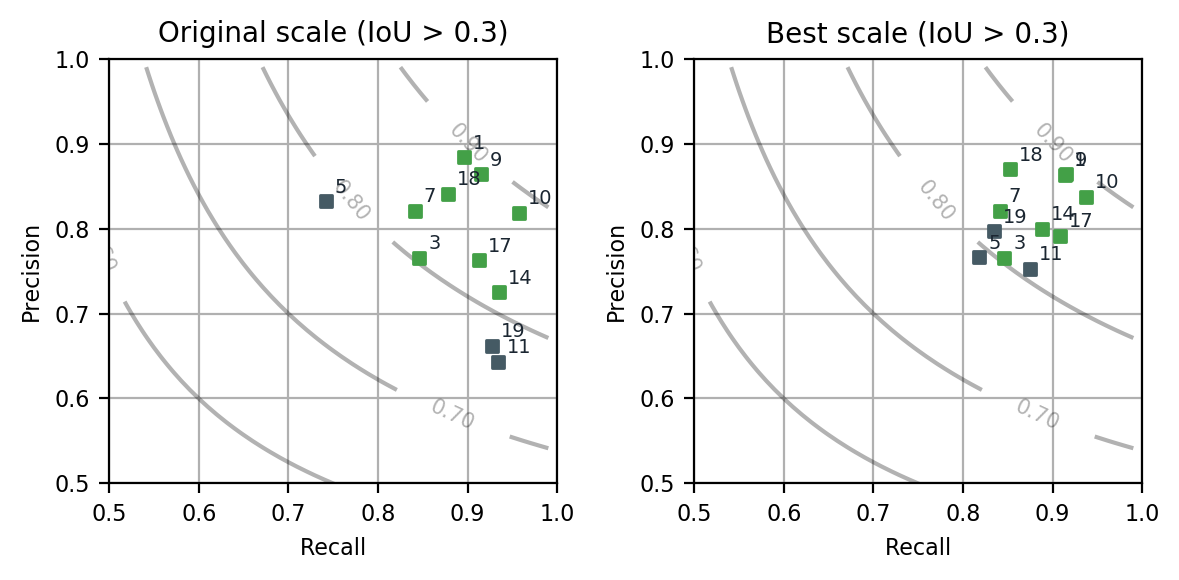

In [47]:
# Comparison before / after
show_ids = True

title_fontsize = 10
other_fontsize = 8
markersize = 20
alpha = 0.4
text_space = 0.01
axis_lims = [0.5, 1.0]
# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)
levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
levels = [level for level in levels if (level>axis_lims[0] and level<axis_lims[1])]

fig, ax = plt.subplots(1, 2, dpi=200, figsize=(6, 3))

CS = ax[0].contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
ax[0].clabel(CS, fontsize=7.5, fmt='%1.2f')
CS = ax[1].contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
ax[1].clabel(CS, fontsize=7.5, fmt='%1.2f')
[single_ax.set_xlabel('Recall', fontsize=other_fontsize) for single_ax in ax]
[single_ax.set_ylabel('Precision', fontsize=other_fontsize) for single_ax in ax]
[single_ax.set_xlim(axis_lims) for single_ax in ax]
[single_ax.set_ylim(axis_lims) for single_ax in ax]
[single_ax.tick_params(labelsize=other_fontsize) for single_ax in ax]
[single_ax.grid() for single_ax in ax]

# Original scale
ax[0].set_title('Original scale (IoU > %1.1f)' % iou_thr, fontsize=title_fontsize)
for i in range(len(ids_dict[set_name])):
    subject_id = ids_dict[set_name][i]
    this_recall = scaling_stats[1.0][i]['recall']
    this_precision = scaling_stats[1.0][i]['precision']
    ax[0].scatter(this_recall, this_precision, c=subject_color_dict[subject_id], marker='s', s=markersize, zorder=10)
    if show_ids:
        ax[0].annotate(
            subject_id, 
            (this_recall+text_space, this_precision+text_space), 
            fontsize=7, color=CUSTOM_COLOR['dark'], zorder=20)

# Best scale
ax[1].set_title('Best scale (IoU > %1.1f)' % iou_thr, fontsize=title_fontsize)
for i in range(len(ids_dict[set_name])):
    subject_id = ids_dict[set_name][i]
    this_recall = scaling_stats[best_scale_dict[subject_id]][i]['recall']
    this_precision = scaling_stats[best_scale_dict[subject_id]][i]['precision']
    ax[1].scatter(this_recall, this_precision, c=subject_color_dict[subject_id], marker='s', s=markersize, zorder=10)
    if show_ids:
        ax[1].annotate(
            subject_id, 
            (this_recall+text_space, this_precision+text_space), 
            fontsize=7, color=CUSTOM_COLOR['dark'], zorder=20)
plt.tight_layout()
plt.show()

In [42]:
# ---------------- Compute performance
f1_vs_iou_subject_dict = {}
pre_vs_iou_subject_dict = {}
rec_vs_iou_subject_dict = {}
iou_list = np.arange(21) * 0.05

# original performance
print('Processing original performance', flush=True)
f1_vs_iou_dict = {}
pre_vs_iou_dict = {}
rec_vs_iou_dict = {}
for subject_id in ids_dict[set_name]:
    subj_events = data_inference.get_subject_stamps(subject_id=subject_id)
    prediction_set = predictions_dict[1.0]
    prediction_set.set_probability_threshold(scaling_optimal_thr)
    subj_detections = prediction_set.get_subject_stamps(subject_id=subject_id)
    this_precision = metrics.metric_vs_iou(subj_events, subj_detections, iou_list, metric_name=constants.PRECISION)
    this_recall = metrics.metric_vs_iou(subj_events, subj_detections, iou_list, metric_name=constants.RECALL)
    this_f1 = 2 * this_precision * this_recall / (this_precision + this_recall + 1e-8)
    f1_vs_iou_dict[subject_id] = this_f1
    pre_vs_iou_dict[subject_id] = this_precision
    rec_vs_iou_dict[subject_id] = this_recall
print('Done', flush=True)

# best performance
print('Processing best scale performance', flush=True)
best_f1_vs_iou_dict = {}
best_pre_vs_iou_dict = {}
best_rec_vs_iou_dict = {}
for subject_id in ids_dict[set_name]:
    subj_events = data_inference.get_subject_stamps(subject_id=subject_id)
    prediction_set = predictions_dict[best_scale_dict[subject_id]]
    prediction_set.set_probability_threshold(scaling_optimal_thr)
    subj_detections = prediction_set.get_subject_stamps(subject_id=subject_id)
    this_precision = metrics.metric_vs_iou(subj_events, subj_detections, iou_list, metric_name=constants.PRECISION)
    this_recall = metrics.metric_vs_iou(subj_events, subj_detections, iou_list, metric_name=constants.RECALL)
    this_f1 = 2 * this_precision * this_recall / (this_precision + this_recall + 1e-8)
    best_f1_vs_iou_dict[subject_id] = this_f1
    best_pre_vs_iou_dict[subject_id] = this_precision
    best_rec_vs_iou_dict[subject_id] = this_recall
print('Done', flush=True)

Processing original performance
Done
Processing best scale performance
Done


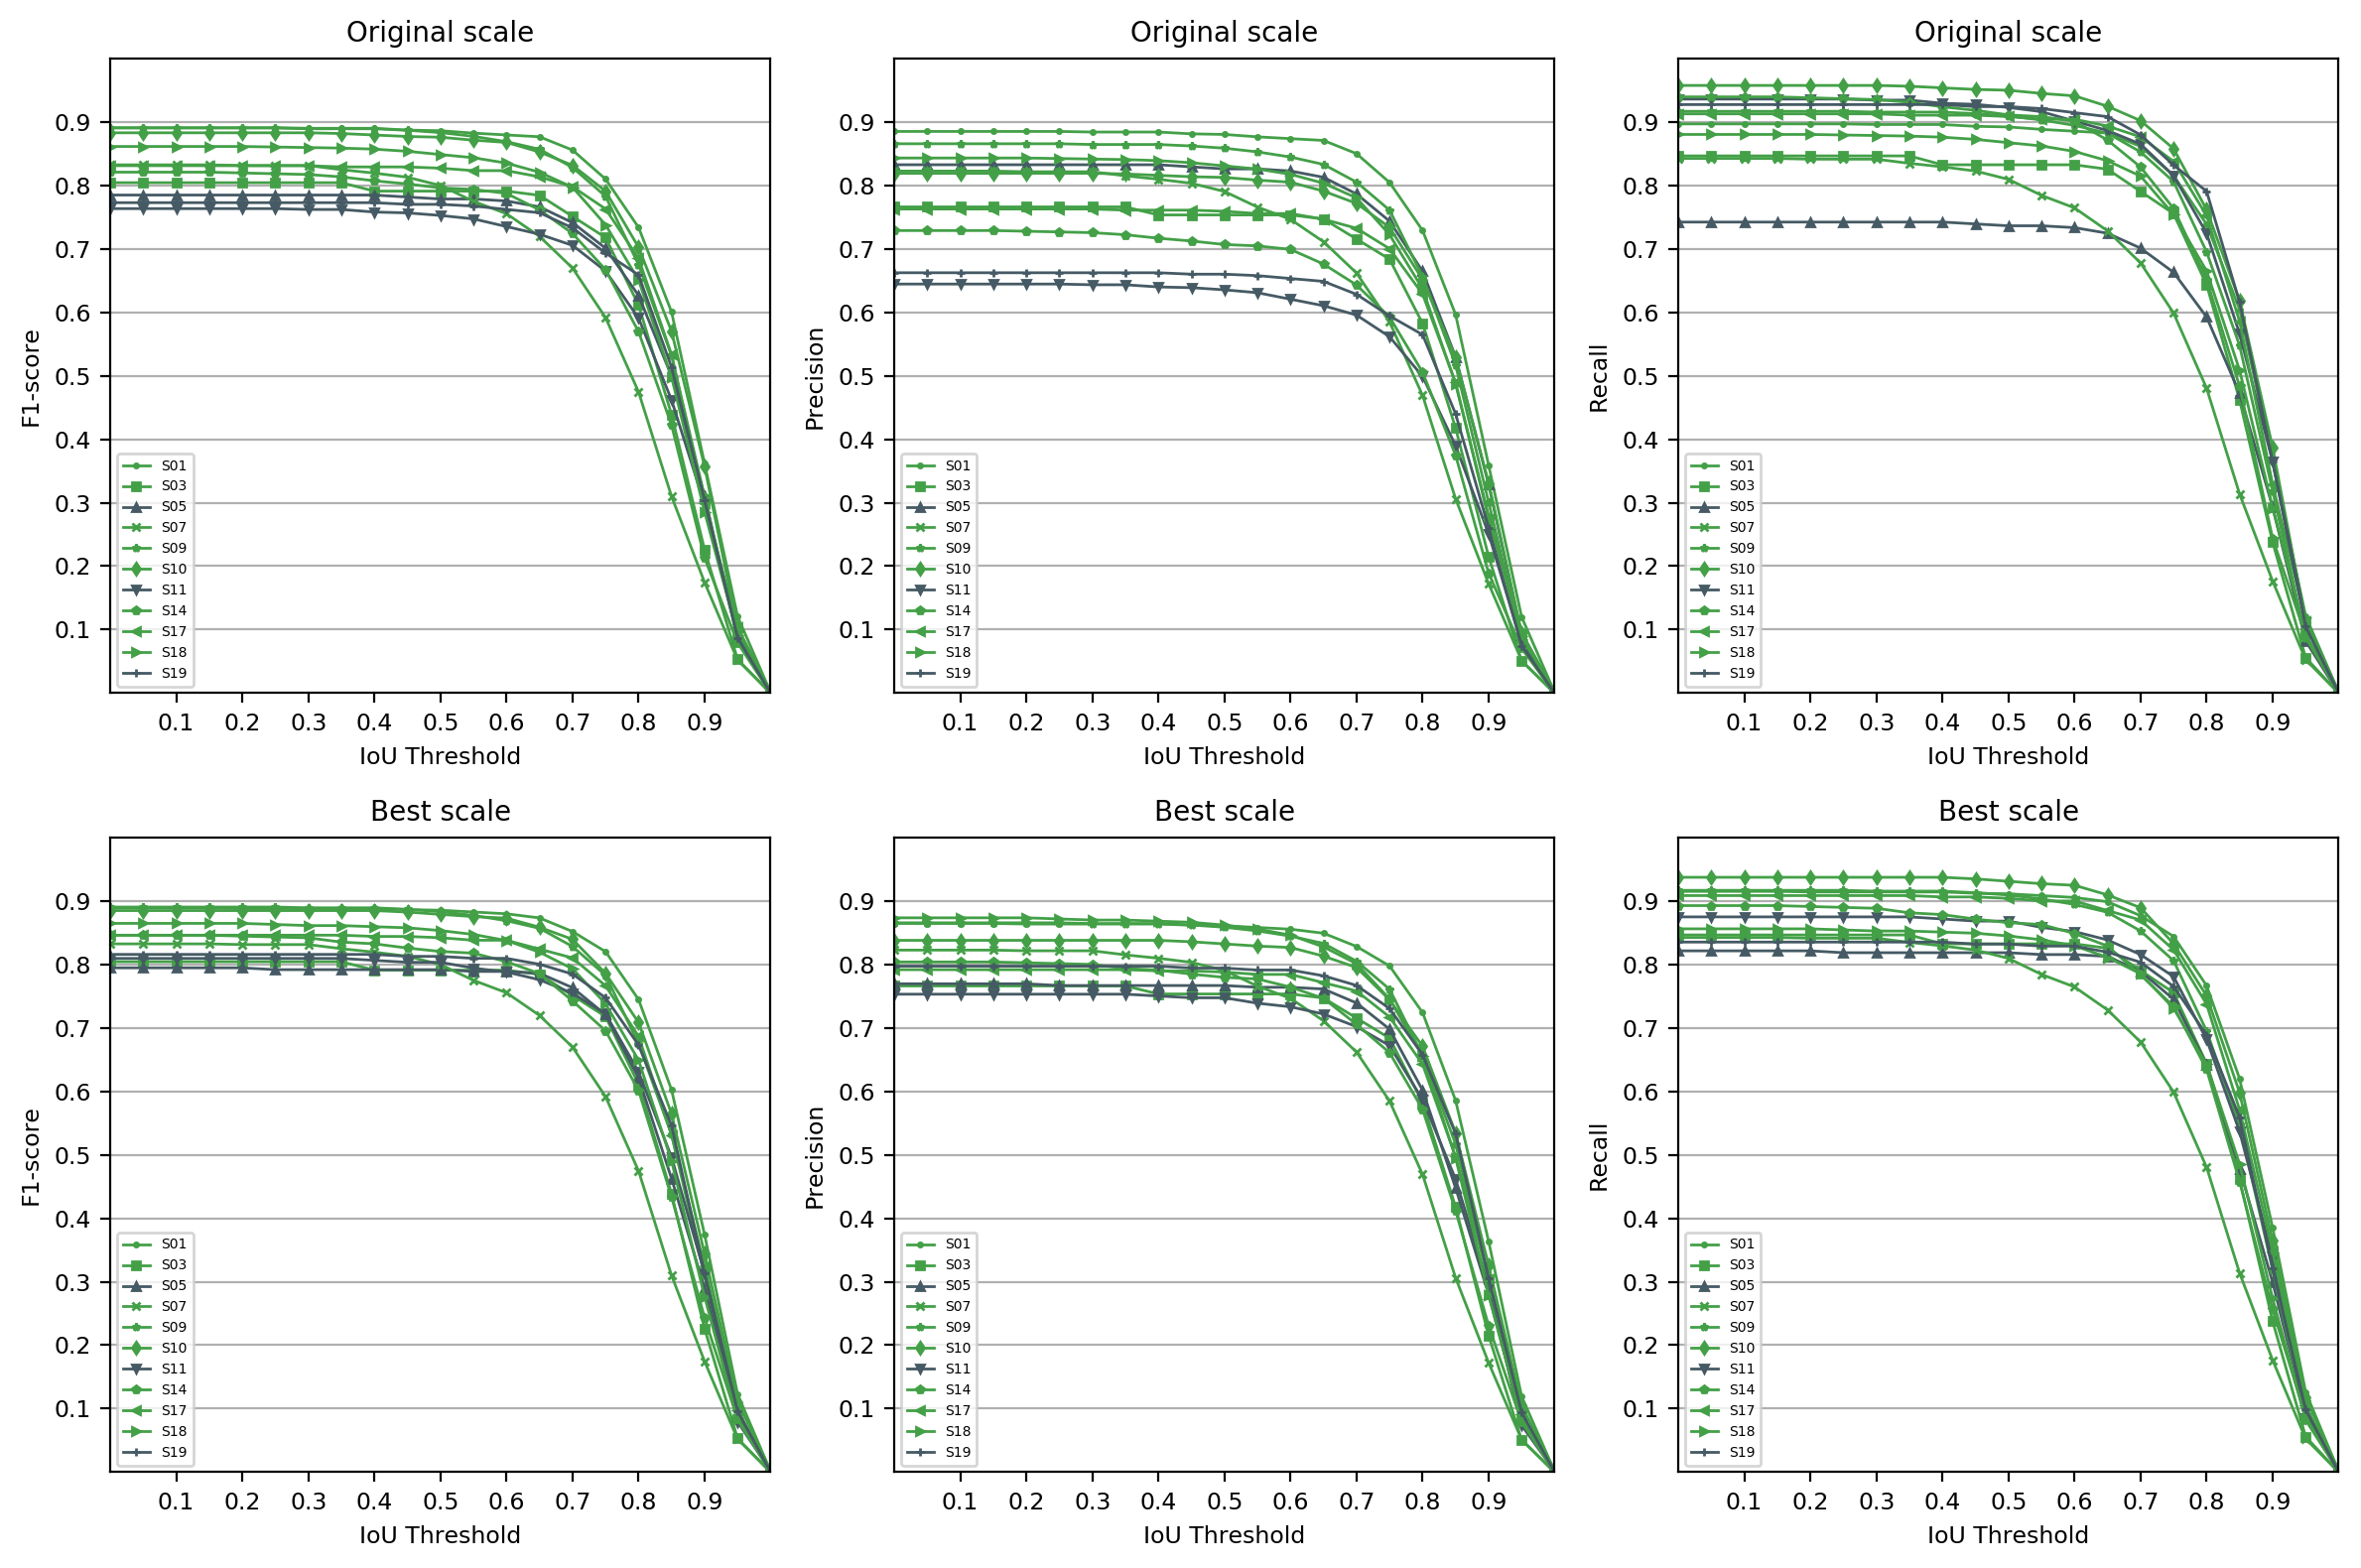

In [52]:
marker_list = ['.', 's', '^', 'x', '*', 'd', 'v', 'p', '<', '>', '+']
linewidth_model = 1
markersize_model = 3

# -------------------- P L O T ----------------------    
    
fig, ax = plt.subplots(2, 3, figsize=(12, 8), dpi=DPI)

# F1
for i, subject_id in enumerate(ids_dict[set_name]):
    ax[0, 0].plot(iou_list, f1_vs_iou_dict[subject_id], 
               linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
               label='S%02d' % subject_id, color=subject_color_dict[subject_id])

ax[0, 0].set_title('Original scale', fontsize=title_fontsize)
ax[0, 0].set_xlim([0, 1])
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_yticks([0.1*i for i in range(1, 10)])
ax[0, 0].set_xticks([0.1*i for i in range(1, 10)])
ax[0, 0].tick_params(labelsize=8.5)
ax[0, 0].set_xlabel('IoU Threshold', fontsize=8.5)
ax[0, 0].set_ylabel('F1-score', fontsize=8.5)
ax[0, 0].yaxis.grid()
ax[0, 0].legend(loc='lower left', fontsize=5)

# Precision
for i, subject_id in enumerate(ids_dict[set_name]):
    ax[0, 1].plot(iou_list, pre_vs_iou_dict[subject_id], 
               linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
               label='S%02d' % subject_id, color=subject_color_dict[subject_id])

ax[0, 1].set_title('Original scale', fontsize=title_fontsize)
ax[0, 1].set_xlim([0, 1])
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_yticks([0.1*i for i in range(1, 10)])
ax[0, 1].set_xticks([0.1*i for i in range(1, 10)])
ax[0, 1].tick_params(labelsize=8.5)
ax[0, 1].set_xlabel('IoU Threshold', fontsize=8.5)
ax[0, 1].set_ylabel('Precision', fontsize=8.5)
ax[0, 1].yaxis.grid()
ax[0, 1].legend(loc='lower left', fontsize=5)

# Recall
for i, subject_id in enumerate(ids_dict[set_name]):
    ax[0, 2].plot(iou_list, rec_vs_iou_dict[subject_id], 
               linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
               label='S%02d' % subject_id, color=subject_color_dict[subject_id])

    
ax[0, 2].set_title('Original scale', fontsize=title_fontsize)
ax[0, 2].set_xlim([0, 1])
ax[0, 2].set_ylim([0, 1])
ax[0, 2].set_yticks([0.1*i for i in range(1, 10)])
ax[0, 2].set_xticks([0.1*i for i in range(1, 10)])
ax[0, 2].tick_params(labelsize=8.5)
ax[0, 2].set_xlabel('IoU Threshold', fontsize=8.5)
ax[0, 2].set_ylabel('Recall', fontsize=8.5)
ax[0, 2].yaxis.grid()
ax[0, 2].legend(loc='lower left', fontsize=5)

# Best scale
for i, subject_id in enumerate(ids_dict[set_name]):
    ax[1, 0].plot(iou_list, best_f1_vs_iou_dict[subject_id], 
               linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
               label='S%02d' % subject_id, color=subject_color_dict[subject_id])

ax[1, 0].set_title('Best scale', fontsize=title_fontsize)
ax[1, 0].set_xlim([0, 1])
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_yticks([0.1*i for i in range(1, 10)])
ax[1, 0].set_xticks([0.1*i for i in range(1, 10)])
ax[1, 0].tick_params(labelsize=8.5)
ax[1, 0].set_xlabel('IoU Threshold', fontsize=8.5)
ax[1, 0].set_ylabel('F1-score', fontsize=8.5)
ax[1, 0].yaxis.grid()
ax[1, 0].legend(loc='lower left', fontsize=5)

# Precision
for i, subject_id in enumerate(ids_dict[set_name]):
    ax[1, 1].plot(iou_list, best_pre_vs_iou_dict[subject_id], 
               linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
               label='S%02d' % subject_id, color=subject_color_dict[subject_id])

ax[1, 1].set_title('Best scale', fontsize=title_fontsize)
ax[1, 1].set_xlim([0, 1])
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_yticks([0.1*i for i in range(1, 10)])
ax[1, 1].set_xticks([0.1*i for i in range(1, 10)])
ax[1, 1].tick_params(labelsize=8.5)
ax[1, 1].set_xlabel('IoU Threshold', fontsize=8.5)
ax[1, 1].set_ylabel('Precision', fontsize=8.5)
ax[1, 1].yaxis.grid()
ax[1, 1].legend(loc='lower left', fontsize=5)

# Recall
for i, subject_id in enumerate(ids_dict[set_name]):
    ax[1, 2].plot(iou_list, best_rec_vs_iou_dict[subject_id], 
               linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
               label='S%02d' % subject_id, color=subject_color_dict[subject_id])

    
ax[1, 2].set_title('Best scale', fontsize=title_fontsize)
ax[1, 2].set_xlim([0, 1])
ax[1, 2].set_ylim([0, 1])
ax[1, 2].set_yticks([0.1*i for i in range(1, 10)])
ax[1, 2].set_xticks([0.1*i for i in range(1, 10)])
ax[1, 2].tick_params(labelsize=8.5)
ax[1, 2].set_xlabel('IoU Threshold', fontsize=8.5)
ax[1, 2].set_ylabel('Recall', fontsize=8.5)
ax[1, 2].yaxis.grid()
ax[1, 2].legend(loc='lower left', fontsize=5)

plt.tight_layout()
plt.show()

## Performance Results - Ablation

In [ ]:
ckpt_dict = {}

ckpt_dict['v11'] = {
    os.path.join('20190608_bsf_ablation_n2_train_mass_ss', 'v11_tf_64-128-256_cwtf_None-None/rep0'): [0.56, 0.54, 0.54, 0.48],
    os.path.join('20190608_bsf_ablation_n2_train_mass_ss', 'v11_tf_64-128-256_cwtf_None-None/rep1'): [0.6, 0.58, 0.5, 0.46],
    os.path.join('20190608_bsf_ablation_n2_train_mass_kc', 'v11_tf_64-128-256_cwtf_None-None/rep0'): [0.48, 0.6, 0.68, 0.6],
    os.path.join('20190608_bsf_ablation_n2_train_mass_kc', 'v11_tf_64-128-256_cwtf_None-None/rep1'): [0.54, 0.62, 0.56, 0.58],
    os.path.join('20190608_bsf_ablation_n2_train_inta_ss', 'v11_tf_64-128-256_cwtf_None-None/rep0'): [0.46, 0.5, 0.5, 0.44],
    os.path.join('20190608_bsf_ablation_n2_train_inta_ss', 'v11_tf_64-128-256_cwtf_None-None/rep1'): [0.44, 0.52, 0.48, 0.46],
}
ckpt_dict['v12'] = {
    os.path.join('20190608_bsf_ablation_n2_train_mass_ss', 'v12_tf_None-None-None_cwtf_32-64/rep0'): [0.66, 0.4, 0.56, 0.52],
    os.path.join('20190608_bsf_ablation_n2_train_mass_ss', 'v12_tf_None-None-None_cwtf_32-64/rep1'): [0.58, 0.46, 0.38, 0.46],
    os.path.join('20190608_bsf_ablation_n2_train_mass_kc', 'v12_tf_None-None-None_cwtf_32-64/rep0'): [0.46, 0.52, 0.48, 0.54],
    os.path.join('20190608_bsf_ablation_n2_train_mass_kc', 'v12_tf_None-None-None_cwtf_32-64/rep1'): [0.52, 0.58, 0.52, 0.46],
    os.path.join('20190608_bsf_ablation_n2_train_inta_ss', 'v12_tf_None-None-None_cwtf_32-64/rep0'): [0.46, 0.46, 0.48, 0.5],
    os.path.join('20190608_bsf_ablation_n2_train_inta_ss', 'v12_tf_None-None-None_cwtf_32-64/rep1'): [0.48, 0.48, 0.48, 0.46],
}
ckpt_dict['v15'] = {
    os.path.join('20190608_bsf_ablation_n2_train_mass_ss', 'v15_tf_64-128-256_cwtf_32-32/rep0'): [0.62, 0.62, 0.4, 0.42],
    os.path.join('20190608_bsf_ablation_n2_train_mass_ss', 'v15_tf_64-128-256_cwtf_32-32/rep1'): [0.64, 0.54, 0.6, 0.46],
    os.path.join('20190608_bsf_ablation_n2_train_mass_kc', 'v15_tf_64-128-256_cwtf_32-32/rep0'): [0.68, 0.54, 0.66, 0.52], 
    os.path.join('20190608_bsf_ablation_n2_train_mass_kc', 'v15_tf_64-128-256_cwtf_32-32/rep1'): [0.72, 0.54, 0.44, 0.56],
    os.path.join('20190608_bsf_ablation_n2_train_inta_ss', 'v15_tf_64-128-256_cwtf_32-32/rep0'): [0.48, 0.52, 0.5, 0.5],
    os.path.join('20190608_bsf_ablation_n2_train_inta_ss', 'v15_tf_64-128-256_cwtf_32-32/rep1'): [0.48, 0.52, 0.54, 0.46],
}
task_mode = constants.N2_RECORD
which_expert = 1
dataset_name = constants.INTA_SS_NAME
n_seeds = 4
model_name_list = ['v12', 'v11', 'v15']
model_name_display_dict = {
    'v11': 'Time Domain Model',
    'v12': 'CWT Domain Model',
    'v15': 'Combined Model'
}

dataset = load_dataset(dataset_name)
test_ids = dataset.test_ids
data_test = FeederDataset(
    dataset, test_ids, task_mode, which_expert=which_expert)
this_events = data_test.get_stamps()

predictions_dict = {}
optimal_thr_dict = {}
for model_name in model_name_list:
    predictions_dict[model_name] = []
    optimal_thr_dict[model_name] = []
    this_ckpt_dict = ckpt_dict[model_name]
    useful_keys = [key for key in this_ckpt_dict.keys() if dataset_name in key]
    # Read predictions
    for key in useful_keys:
        for k in range(n_seeds):
            ckpt_path = os.path.abspath(os.path.join(RESULTS_PATH, 'predictions_%s' % dataset_name, key, 'seed%d' % k))
            filename = os.path.join(ckpt_path, 'prediction_%s_test.pkl' % task_mode)
            with open(filename, 'rb') as handle:
                this_pred = RefactorUnpickler(handle).load()
            predictions_dict[model_name].append(this_pred)
            optimal_thr_dict[model_name].append(this_ckpt_dict[key][k])
print('Predictions loaded')

In [ ]:
# Measure AF1 and F1 vs IoU
print('Measuring F1')
af1_dict = {}
f1_vs_iou_dict = {}
iou_list = np.arange(1, 10) * 0.1
for model_name in model_name_list:
    print('Measuring model %s' % model_name, flush=True)
    af1_dict[model_name] = []
    f1_vs_iou_dict[model_name] = []
    for optimal_thr, predictions in zip(optimal_thr_dict[model_name], predictions_dict[model_name]):
        predictions.set_probability_threshold(optimal_thr)
        this_detections = predictions.get_stamps()
        af1_at_thr = metrics.average_metric_with_list(this_events, this_detections, verbose=False)
        af1_dict[model_name].append(af1_at_thr)
        this_f1_vs_iou = metrics.metric_vs_iou_with_list(this_events, this_detections, iou_list)
        f1_vs_iou_dict[model_name].append(this_f1_vs_iou)
# Mean results
mean_af1_dict = {}
mean_f1_vs_iou_dict = {}
for model_name in model_name_list:
    mean_af1 = np.mean(af1_dict[model_name])
    std_af1 = np.std(af1_dict[model_name])
    
    mean_curve = np.stack(f1_vs_iou_dict[model_name], axis=1).mean(axis=1)
    std_curve = np.stack(f1_vs_iou_dict[model_name], axis=1).std(axis=1)
    
    mean_af1_dict[model_name] = (mean_af1, std_af1)
    mean_f1_vs_iou_dict[model_name] = (mean_curve, std_curve)
print('Done')

In [ ]:
round_precision = 2
print('Test AF1 for %s' % dataset_name)
for model_name in model_name_list:
    print('%s: %1.2f +- %1.2f' 
          % (
              model_name_display_dict[model_name].ljust(20), 
              np.round(100*mean_af1_dict[model_name][0], decimals=round_precision), 
              np.round(100*mean_af1_dict[model_name][1], decimals=round_precision)))

In [ ]:
alpha = 0.3
color_list = {'v15': CUSTOM_COLOR['red'] , 'expert': CUSTOM_COLOR['grey'], 'v11': CUSTOM_COLOR['blue'], 'v12': CUSTOM_COLOR['green']}
linewidth = 1.5
markersize = 7
title_fontsize = 10
other_fontsize = 8
show_std = True

# -------------------- P L O T ----------------------    

# Comparison data
compare_expert = dataset.event_name == constants.SPINDLE
if compare_expert:
    expert_f1_curve_mean = np.loadtxt(os.path.join(COMPARISON_PATH, 'expert', 'ss_f1_vs_iou_expert_mean.csv'), delimiter=',')
    expert_f1_curve_std = np.loadtxt(os.path.join(COMPARISON_PATH, 'expert', 'ss_f1_vs_iou_expert_std.csv'), delimiter=',')
    expert_f1_curve_mean = expert_f1_curve_mean[1:, :]
    expert_f1_curve_std = expert_f1_curve_std[1:, :]
    
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)

# Complete plot
if compare_expert:
    ax.plot(expert_f1_curve_mean[:, 0], expert_f1_curve_mean[:, 1], linewidth=linewidth, 
               label='Expert Performance\nPrivate Dataset\nWarby et al. 2014', color=color_list['expert'])
    ax.plot(expert_f1_curve_mean[:, 0], expert_f1_curve_mean[:, 1], linestyle='none', 
               markersize=markersize, marker='.', color=color_list['expert'])
    ax.fill_between(
        expert_f1_curve_mean[:, 0], 
        expert_f1_curve_mean[:, 1] - expert_f1_curve_std[:, 1], 
        expert_f1_curve_mean[:, 1] + expert_f1_curve_std[:, 1], 
        alpha=alpha, facecolor=color_list['expert'])

for model_name in model_name_list:
    this_name = model_name_display_dict[model_name]
    ax.plot(iou_list, mean_f1_vs_iou_dict[model_name][0], 
               linewidth=linewidth,
               label='%s' % this_name, color=color_list[model_name])
    ax.plot(iou_list, mean_f1_vs_iou_dict[model_name][0], 
               linestyle='none', markersize=markersize, marker='.', 
               color=color_list[model_name])
    if show_std:
        ax.fill_between(iou_list, 
                        mean_f1_vs_iou_dict[model_name][0] - mean_f1_vs_iou_dict[model_name][1], 
                        mean_f1_vs_iou_dict[model_name][0] + mean_f1_vs_iou_dict[model_name][1], alpha=alpha, facecolor=color_list[model_name])


    
ax.set_title('Test Performance (%s)' % dataset_name.upper(), fontsize=title_fontsize)
ax.set_xlim([0.1 - 0.02, 0.9 + 0.02])
ax.set_ylim([0.1 - 0.02, 0.9 + 0.02])
# ax.set_yticks([0.1*i for i in range(1, 10)])
ax.set_xticks([0.1*i for i in range(1, 10)])
ax.tick_params(labelsize=other_fontsize)
ax.set_xlabel('IoU Threshold', fontsize=other_fontsize)
ax.set_ylabel('F1-score', fontsize=other_fontsize)
ax.yaxis.grid()
ax.legend(loc='lower left', labelspacing=1.5, fontsize=other_fontsize)

plt.show()

In [ ]:
# PR
iou_thr = 0.3
res_thr = 0.02
start_thr = 0.1
end_thr = 0.9
n_thr = int(np.round((end_thr - start_thr) / res_thr + 1))
thr_list = np.array([start_thr + res_thr * i for i in range(n_thr)])

pr_curve_dict = {}
for model_name in model_name_list:
    print('Measuring model %s' % model_name, flush=True)
    pr_curve_dict[model_name] = []
    for k, predictions in enumerate(predictions_dict[model_name]):
        pr_curve_dict[model_name].append(np.zeros((n_thr, 2)))
        for i, thr in enumerate(thr_list):
            predictions.set_probability_threshold(thr)
            this_detections = predictions.get_stamps()
            this_stats = [metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
                        for (this_y, this_y_pred) in zip(this_events, this_detections)]
            this_recall = np.mean([m[constants.RECALL] for m in this_stats])
            this_precision = np.mean([m[constants.PRECISION] for m in this_stats])
            pr_curve_dict[model_name][k][i, 0] = this_recall
            pr_curve_dict[model_name][k][i, 1] = this_precision
print('Done', flush=True)

In [ ]:
# Plot 
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)
markersize = 6
alpha = 0.3
text_space = 0.01
compare_expert = dataset.event_name == constants.SPINDLE
axis_lims = [0.5, 1.0]
color_list = {'v15': CUSTOM_COLOR['red'] , 'expert': CUSTOM_COLOR['grey'], 'v11': CUSTOM_COLOR['blue'], 'v12': CUSTOM_COLOR['green']}
title_fontsize = 10
other_fontsize = 8

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)
levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
levels = [level for level in levels if (level>axis_lims[0] and level<axis_lims[1])]
CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
ax.clabel(CS, fontsize=7.5, fmt='%1.2f')
    
if compare_expert:
    expert_pr_mean = np.loadtxt(os.path.join(COMPARISON_PATH, 'expert', 'ss_pr_expert_mean.csv'), delimiter=',')
    ax.scatter(expert_pr_mean[0], expert_pr_mean[1], s=50, c=color_list['expert'], zorder=10, label='Expert Performance\nPrivate Dataset\nWarby et al. 2014')
    
for model_name in model_name_list:
    mean_precision = []
    mean_recall = []
    for k, pr_curve in enumerate(pr_curve_dict[model_name]):
        if k == 0:
            label = model_name_display_dict[model_name]
        else:
            label = None
        thr_run = optimal_thr_dict[model_name][k]
        chosen_thr_idx = np.where(np.isclose(thr_list, thr_run))[0].item()
        ax.plot(pr_curve[:, 0], pr_curve[:, 1], linewidth=1, color=color_list[model_name], zorder=7, alpha=alpha, label=label)
        mean_precision.append(pr_curve[chosen_thr_idx, 1])
        mean_recall.append(pr_curve[chosen_thr_idx, 0])
    mean_precision = np.mean(mean_precision)
    mean_recall = np.mean(mean_recall)
    ax.scatter(mean_recall, mean_precision, s=50, c=color_list[model_name], zorder=10)

ax.set_title('Test PR Curve with IoU$>$%1.1f (%s)' % (iou_thr, dataset_name.upper()), fontsize=10)
ax.set_xlabel('Recall', fontsize=8.5)
ax.set_ylabel('Precision', fontsize=8.5)
ax.set_xlim(axis_lims)
ax.set_ylim(axis_lims)

lg = ax.legend(loc='lower left', labelspacing=1, fontsize=6.5)
for lh in lg.legendHandles:
    lh.set_alpha(1.0)

ax.tick_params(labelsize=8.5)
ax.grid()
plt.show()

## SS and KC example

In [8]:
subject_id = 1
dataset = load_dataset(constants.MASS_SS_NAME)
signal = dataset.get_subject_signal(subject_id=subject_id, normalize_clip=False)
stamps_ss = dataset.get_subject_stamps(subject_id=subject_id)
dataset = load_dataset(constants.MASS_KC_NAME)
stamps_kc = dataset.get_subject_stamps(subject_id=subject_id)
fs = dataset.fs

print('%d SS stamps.' % stamps_ss.shape[0])
print('%d KC stamps.' % stamps_kc.shape[0])

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_kc with 15 patients.
Loading from checkpoint... Loaded
1044 SS stamps.
409 KC stamps.


In [9]:
def filter_stamps(stamps, start_sample, end_sample):
    pages_list = []
    for i in range(stamps.shape[0]):
        start_inside = (stamps[i, 0] > start_sample) and (stamps[i, 0] < end_sample)
        end_inside = (stamps[i, 1] > start_sample) and (stamps[i, 1] < end_sample)

        if start_inside or end_inside:
            pages_list.append(stamps[i, :])
    return pages_list

In [51]:
def plot_segment(which_kc_stamp):
    left_context = 3
    right_context = 7
    segment_size = left_context + right_context
    central_sample = stamps_kc[which_kc_stamp, :].mean()
    start_sample = int(central_sample - fs * left_context)
    end_sample = int(central_sample + fs * right_context)

    segment_stamps_ss = filter_stamps(stamps_ss, start_sample, end_sample)
    segment_stamps_kc = filter_stamps(stamps_kc, start_sample, end_sample)
    segment_signal = signal[start_sample:end_sample]
    time_axis = np.arange(start_sample, end_sample) / fs

    title_fontsize = 10
    other_fontsize = 8
    fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5, 2))

    y_max = 150                   
    ax.plot(
        time_axis, segment_signal, 
        linewidth=1, color=CUSTOM_COLOR['grey'], label='EEG C3-CLE')
    stamp_label_used = False
    for stamp in segment_stamps_ss:
        if stamp_label_used:
            label = None
        else:
            label = 'SS Mark'
            stamp_label_used = True
        ax.fill_between(
            stamp / fs, y_max, -y_max, 
            facecolor=CUSTOM_COLOR['red'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    stamp_label_used = False
    for stamp in segment_stamps_kc:
        if stamp_label_used:
            label = None
        else:
            label = 'KC Mark'
            stamp_label_used = True
        ax.fill_between(
            stamp / fs, y_max, -y_max, 
            facecolor=CUSTOM_COLOR['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_xlabel('Time [s]', fontsize=other_fontsize)
    ax.set_ylabel('Voltage [$\mu$V]', fontsize=other_fontsize)
    # ax.set_yticks([-y_max, 0, y_max])
    ax.set_yticks([])
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.set_ylim([-y_max, y_max])
    # ticks_array = time_axis[0] + np.arange(0, segment_size+1, 5)
    # ax.set_xticks(ticks_array)
    ax.set_xticks([])
    ax.set_xticks(np.arange(time_axis[0], time_axis[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=other_fontsize-1)
    ax.tick_params(labelsize=other_fontsize)
    plt.show()

In [52]:
widgets.interact(
    lambda which_kc_stamp: plot_segment(which_kc_stamp),
    which_kc_stamp=widgets.IntSlider(min=0,max=stamps_kc.shape[0]-1,step=1,value=195, continuous_update=False));

interactive(children=(IntSlider(value=195, continuous_update=False, description='which_kc_stamp', max=408), Ou…